In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from glob import glob
import os
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
" Seeding """
np.random.seed(42)
tf.random.set_seed(42)


In [3]:
SIZE=256
def read_image_tf(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (SIZE, SIZE))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask_tf(path):
    path = path.decode()
    y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (SIZE, SIZE))
    y[y != 0] = 255
    y = y / 255.0
    y = (y > 0.5).astype(np.float32)
    y = np.expand_dims(y, axis=-1)
    return y

def tf_parse(x_path, y_path):
    def _parse(x_path, y_path):
        x = read_image_tf(x_path)
        y = read_mask_tf(y_path)
        return x, y

    x, y = tf.numpy_function(_parse, [x_path, y_path], [tf.float32, tf.float32])
    x.set_shape([SIZE, SIZE, 3])
    y.set_shape([SIZE, SIZE, 1])
    return x, y

def tf_dataset(x_paths, y_paths, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [4]:
def iou(y_true, y_pred):
    y_true = tf.round(y_true)
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-15) / (union + 1e-15)
    return iou


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=False),
    TensorBoard()

]

In [6]:

import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
weight_decay=1e-8
def conv_block(x, filters, dropout=False):
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    if dropout:
        x = layers.Dropout(0.5)(x)

    return x


def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    # Apply dropout in encoder 4
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [7]:
train_y = '/content/drive/MyDrive/PFA_Final/new_data/train/GT_ZP'
train_x = '/content/drive/MyDrive/PFA_Final/new_data/train/images'
test_y = '/content/drive/MyDrive/PFA_Final/new_data/test/GT_ZP'
test_x = '/content/drive/MyDrive/PFA_Final/new_data/test/images'
valid_y = '/content/drive/MyDrive/PFA_Final/new_data/valid/GT_ZP'
valid_x = '/content/drive/MyDrive/PFA_Final/new_data/valid/images'

train_images = sorted(glob(os.path.join(train_x, "*.bmp")))
train_masks  = sorted(glob(os.path.join(train_y, "*.bmp")))

test_images = sorted(glob(os.path.join(test_x, "*.bmp")))
test_masks  = sorted(glob(os.path.join(test_y, "*.bmp")))

valid_images = sorted(glob(os.path.join(valid_x, "*.bmp")))
valid_masks  = sorted(glob(os.path.join(valid_y, "*.bmp")))

# Create datasets
train_dataset = tf_dataset(train_images, train_masks, batch_size=16)
test_dataset  = tf_dataset(test_images, test_masks, batch_size=16,shuffle=False)
valid_dataset = tf_dataset(valid_images, valid_masks, batch_size=16, shuffle=False)
print("Number of training samples:", len(train_images))
print("Number of validation samples:", len(valid_images))
print("Number of testing samples:", len(test_images))

metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]

Number of training samples: 995
Number of validation samples: 25
Number of testing samples: 25


In [ ]:

input_shape = ((SIZE, SIZE, 3))
modelzp = build_unet(input_shape)
modelzp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,weight_decay=1e-8),
              loss=dice_loss,
              metrics=metrics)

# Train with dataset
modelzp.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    callbacks=callbacks,
)


Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 538s 7s/step - accuracy: 0.7763 - dice_coef: 0.3978 - iou: 0.3179 - loss: 0.6023 - precision: 0.3680 - recall: 0.6147 - val_accuracy: 0.8293 - val_dice_coef: 0.2166 - val_iou: 0.0423 - val_loss: 0.7787 - val_precision: 0.3705 - val_recall: 0.0548 - learning_rate: 1.0000e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 818ms/step - accuracy: 0.9302 - dice_coef: 0.7306 - iou: 0.6695 - loss: 0.2694 - precision: 0.7231 - recall: 0.9005 - val_accuracy: 0.8243 - val_dice_coef: 0.2210 - val_iou: 0.1039 - val_loss: 0.7703 - val_precision: 0.3998 - val_recall: 0.1364 - learning_rate: 1.0000e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 813ms/step - accuracy: 0.9457 - dice_coef: 0.7837 - iou: 0.7261 - loss: 0.2163 - precision: 0.7931 - recall: 0.8967 - val_accuracy: 0.8507 - val_dice_coef: 0.2771 - val_iou: 0.1637 - val_loss: 0.7214 - val_precision: 0.6743 - val_recall: 0.1777 - learning_rate: 1.0000e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step 

In [ ]:
modelzp.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.9665 - dice_coef: 0.9034 - iou: 0.8263 - loss: 0.0980 - precision: 0.8630 - recall: 0.9472


[0.09626275300979614,
 0.9057223796844482,
 0.8304380774497986,
 0.9677606225013733,
 0.9492618441581726,
 0.8641226887702942]

In [ ]:
def channel_attention(x, ratio=2, name_prefix="attention"):
    channel = x.shape[-1]
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', name=f"{name_prefix}_dense1")
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', name=f"{name_prefix}_dense2")

    avg_pool = layers.GlobalAveragePooling2D()(x)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = layers.GlobalMaxPooling2D()(x)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    out = layers.Add(name=f"{name_prefix}_add")([avg_out, max_out])
    attention = layers.Activation('sigmoid', name=f"{name_prefix}_sigmoid")(out)

    scaled = layers.Multiply(name=f"{name_prefix}_multiply")([x, attention])
    out = layers.Add(name=f"{name_prefix}_final_add")([scaled, x])

    return out, attention, scaled


In [ ]:
def decoder_blockch(x, skip, filters, name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same", name=f"{name_prefix}_conv_transpose")(x)
    x = layers.Concatenate(name=f"{name_prefix}_concat")([x, skip])
    x = conv_block(x, filters)
    out, attention, scaled = channel_attention(x, name_prefix=f"{name_prefix}_channelattention")
    return out, attention, scaled


In [ ]:
def build_unetch_with_attention_features(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    b1 = conv_block(p4, 1024, dropout=True)

    d1, att1, feat1 = decoder_blockch(b1, s4, 512, name_prefix="decoder1")
    d2, att2, feat2 = decoder_blockch(d1, s3, 256, name_prefix="decoder2")
    d3, att3, feat3 = decoder_blockch(d2, s2, 128, name_prefix="decoder3")
    d4, att4, feat4 = decoder_blockch(d3, s1, 64, name_prefix="decoder4")


    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs= outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelzp_ch = build_unetch_with_attention_features(input_shape)
modelzp_ch.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
for layer in modelzp_ch.layers:
    print(layer.name)


input_layer
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_6
activation_6
conv2d_7
batch_normalization_7
activation_7
dropout
max_pooling2d_3
conv2d_8
batch_normalization_8
activation_8
conv2d_9
batch_normalization_9
activation_9
dropout_1
decoder1_conv_transpose
decoder1_concat
conv2d_10
batch_normalization_10
activation_10
conv2d_11
batch_normalization_11
activation_11
global_average_pooling2d
global_max_pooling2d
reshape
reshape_1
decoder1_channelattention_dense1
decoder1_channelattention_dense2
decoder1_channelattention_add
decoder1_channelattention_sigmoid
decoder1_channelattention_multiply
decoder1_channelattention_final_add
decoder2_conv_transpose
decoder2_concat
conv2d_12
batch_normalization_12
ac

In [ ]:
layer_names = [
    "decoder1_channelattention_final_add",
    "decoder2_channelattention_final_add",
    "decoder3_channelattention_final_add",
    "decoder4_channelattention_final_add"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_ch.input,
                                   outputs=[modelzp_ch.get_layer(name).output for name in layer_names])



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.5928 - dice_coef: 0.4110 - iou: 0.3084 - loss: 0.5891 - precision: 0.2799 - recall: 0.8672 - val_accuracy: 0.8256 - val_dice_coef: 0.2224 - val_iou: 0.0519 - val_loss: 0.7720 - val_precision: 0.3427 - val_recall: 0.0664 - learning_rate: 1.0000e-04
Epoch 2/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 864ms/step - accuracy: 0.9312 - dice_coef: 0.7540 - iou: 0.6689 - loss: 0.2460 - precision: 0.7321 - recall: 0.8859 - val_accuracy: 0.8285 - val_dice_coef: 0.1579 - val_iou: 0.0453 - val_loss: 0.8374 - val_precision: 0.3580 - val_recall: 0.0547 - learning_rate: 1.0000e-04
Epoch 3/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 868ms/step - accuracy: 0.9478 - dice_coef: 0.8100 - iou: 0.7311 - loss: 0.1900 - precision: 0.8106 - recall: 0.8823 - val_accuracy: 0.8444 - val_dice_coef: 0.1855 - val_iou: 0.0879 - val_loss: 0.8121 - val_precision: 0.7037 - val_recall: 0.0924 - learning_rate: 1.0000e-04
Epoch 4/300
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 860ms/step 

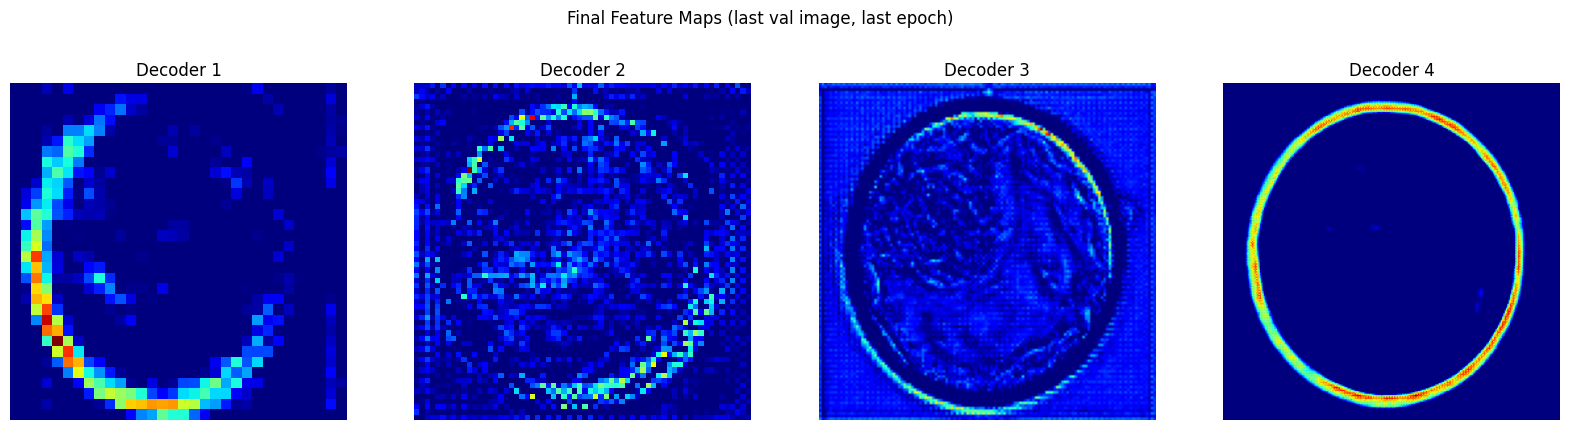

In [ ]:
modelzp_ch.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=300,
    callbacks=[feature_map_callback, callbacks],
)

In [ ]:
modelzp_ch.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9651 - dice_coef: 0.9007 - iou: 0.8213 - loss: 0.1011 - precision: 0.8567 - recall: 0.9465


[0.09875941276550293,
 0.9040161371231079,
 0.8268581628799438,
 0.966625988483429,
 0.9471414089202881,
 0.8600018620491028]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Ensure tf is imported

# Get a test sample (image, mask) from the validation dataset
sample = next(iter(valid_dataset))
sample_img = sample[0][0]  # (H, W, C)
sample_mask = sample[1][0]  # (H, W, 1) or (H, W)

# Expand dims for prediction
sample_img_exp = tf.expand_dims(sample_img, axis=0)  # (1, H, W, C)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


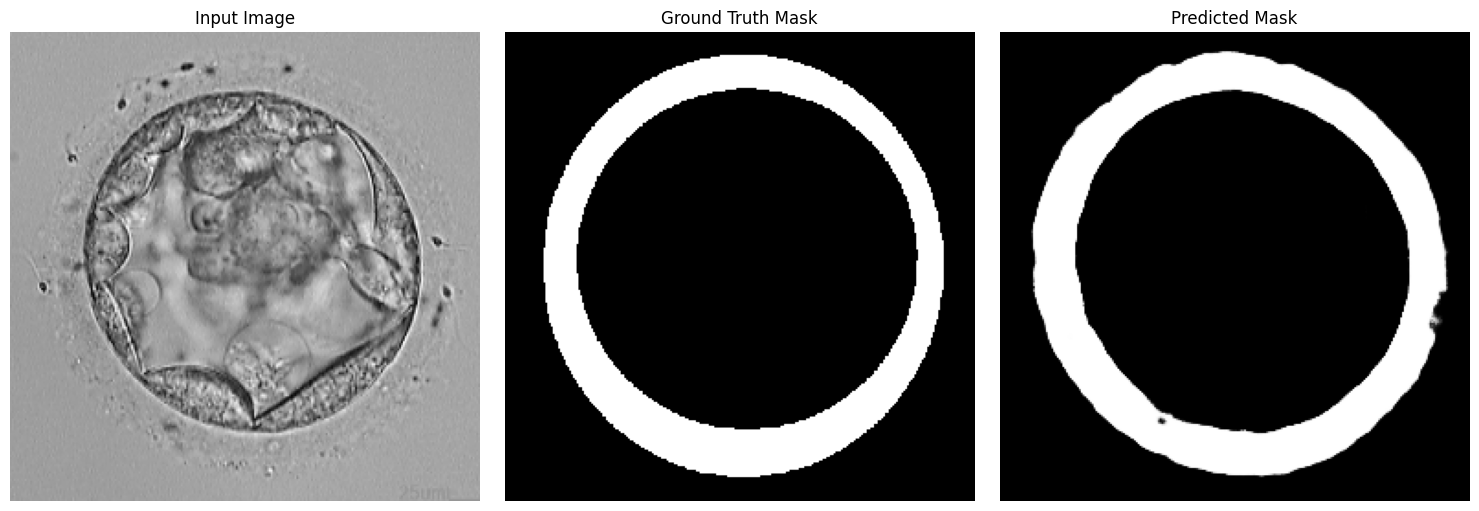

In [ ]:


pred_dict = modelzp_ch.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def plot_feature_map(feature, title):
    plt.imshow(np.mean(feature, axis=-1), cmap='viridis')  # Mean across channels
    plt.title(title)
    plt.colorbar()
    plt.axis('off')

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers

def dual_pathway_spatial_attention(x_l, x_h, out_channels,name_prefix="attention"):
    """
    Dual-pathway AG block: spatial attention for decoder stage s.

    Args:
        x_h: high-level feature map (upsampled from decoder)
        x_l: low-level feature map (from encoder)
        out_channels: number of output channels after ΦC conv (e.g., 64, 32, 16)

    Returns:
        Calibrated feature map after dual-pathway attention.
    """
    def single_path_attention(x_l, x_h):
    # Combine high-level and low-level features
      theta_x_l = layers.Conv2D(out_channels, (1, 1), padding='same')(x_l)
      phi_x_h = layers.Conv2D(out_channels, (1, 1), padding='same')(x_h)
      add = layers.Add()([theta_x_l, phi_x_h])
      act = layers.Activation('relu')(add)

    # Spatial Attention using both average and max pooling
      avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(act)
      max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(act)
      concat_pool = layers.Concatenate(axis=-1)([avg_pool, max_pool])  # Shape: (H, W, 2)

      attention = layers.Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat_pool)
      out = layers.Multiply()([x_l, attention])  # x_l · α

      return out


    # First AG pathway
    ag1 = single_path_attention(x_l, x_h)

    # Second AG pathway (can be made slightly different if needed)
    ag2 = single_path_attention(x_l, x_h)

    # Concatenate both pathways (along channel axis)
    concat = layers.Concatenate(axis=-1)([ag1, ag2])

    # Apply ΦC (1x1 conv + BN + ReLU)
    conv = layers.Conv2D(out_channels, (1, 1), padding='same' , use_bias=False)(concat)
    bn = layers.BatchNormalization()(conv)
    out = layers.Activation('relu',name=f"{name_prefix}_outskip")(bn)

    return out


In [ ]:
def decoder_blocksp(x, skip, filters,name_prefix="decoder"):
    x = conv_block(x, filters*2)
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    xatt = dual_pathway_spatial_attention(skip, x, filters,name_prefix=f"{name_prefix}_dualattention")
    out = layers.Concatenate(axis=-1)([x, xatt])
    out = conv_block(out, filters)
    return out,xatt


In [ ]:
def build_unetsp(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1 = decoder_block(b1, s4, 512)
    d2,f2 = decoder_blocksp(d1, s3, 256,name_prefix="decoder2")
    d3,f3 = decoder_blocksp(d2, s2, 128,name_prefix="decoder3")
    d4,f4 = decoder_blocksp(d3, s1, 64,name_prefix="decoder4")

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid",name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
# Now build and compile model like you did
input_shape = ((SIZE, SIZE, 3))
modelzp_sp = build_unetsp(input_shape)
modelzp_sp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder2_dualattention_outskip",
    "decoder3_dualattention_outskip",
    "decoder4_dualattention_outskip"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_sp.input,
                                   outputs=[modelzp_sp.get_layer(name).output for name in layer_names])

In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 594s 7s/step - accuracy: 0.6586 - dice_coef: 0.3748 - iou: 0.3067 - loss: 0.6252 - precision: 0.3012 - recall: 0.8020 - val_accuracy: 0.8350 - val_dice_coef: 0.1888 - val_iou: 0.0028 - val_loss: 0.8081 - val_precision: 0.3334 - val_recall: 0.0038 - learning_rate: 1.0000e-04
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.9177 - dice_coef: 0.6419 - iou: 0.6429 - loss: 0.3581 - precision: 0.6695 - recall: 0.9413 - val_accuracy: 0.8271 - val_dice_coef: 0.1493 - val_iou: 0.0246 - val_loss: 0.8484 - val_precision: 0.2635 - val_recall: 0.0287 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


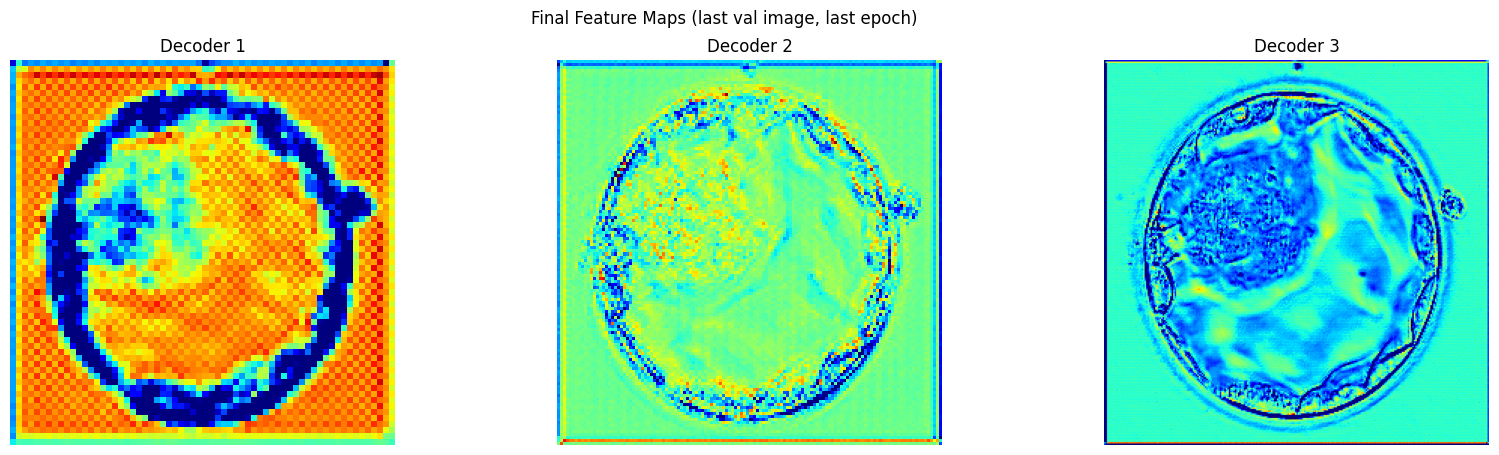

In [ ]:

modelzp_sp.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
    callbacks=[feature_map_callback, callbacks],
)

In [ ]:
modelzp_sp.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.8295 - dice_coef: 0.1484 - iou: 0.0228 - loss: 0.8529 - precision: 0.2608 - recall: 0.0204


[0.8511782288551331,
 0.15088041126728058,
 0.028262585401535034,
 0.8318517804145813,
 0.02454364113509655,
 0.2661247253417969]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


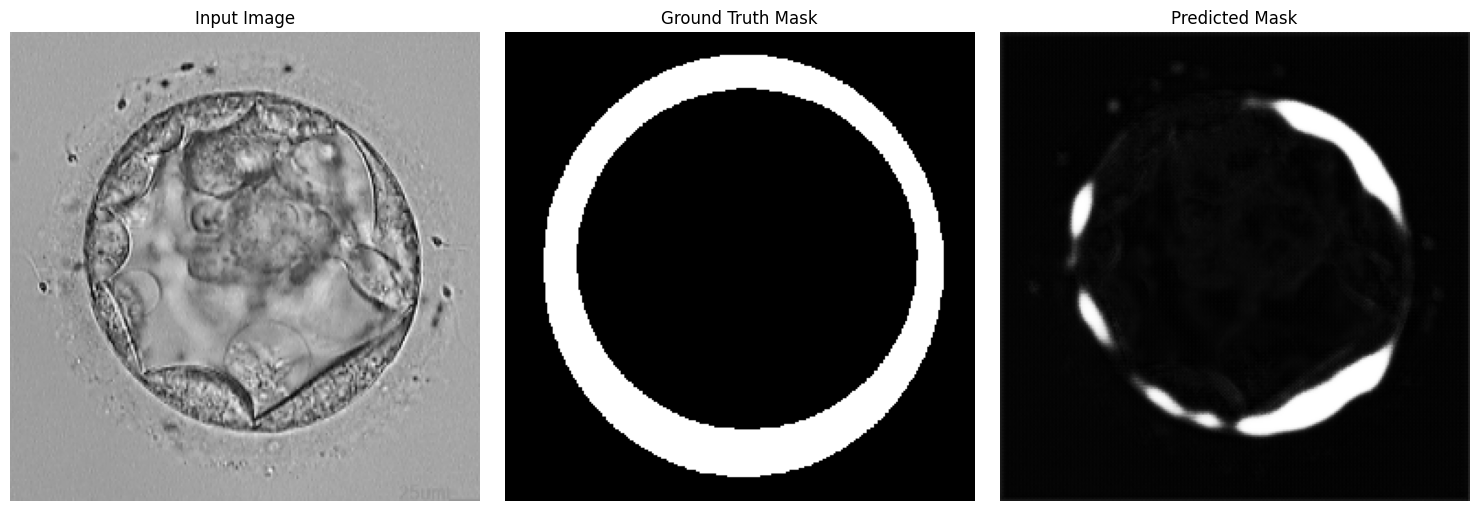

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # Ensure tf is imported

pred_dict = modelzp_sp.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras import layers, backend as K
import tensorflow as tf

def SA1_non_local_attention(x, inter_channels=64,name_prefix="attention"):
    input_channels = x.shape[-1]
    H, W = x.shape[1], x.shape[2]  # Capture symbolic H and W

    # Step 1: Reduce channels
    x_0   = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_00  = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)
    x_000 = layers.Conv2D(inter_channels, (1, 1), padding='same')(x)

    # Step 2: Flatten (B, H, W, C) → (B, H*W, C)
    def reshape_for_attention(y):
        return tf.reshape(y, (tf.shape(y)[0], -1, inter_channels))  # (B, HW, C)

    x_theta = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_0)
    x_phi   = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_00)
    x_g     = layers.Lambda(reshape_for_attention, output_shape=(None, None, inter_channels))(x_000)

    # Step 3: Attention weights
    attention_scores = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1], transpose_b=True),
        output_shape=(None, None, None)
    )([x_theta, x_phi])

    attention = layers.Activation('softmax')(attention_scores)

    # Step 4: Apply attention: α · g
    x_att = layers.Lambda(
        lambda inputs: tf.matmul(inputs[0], inputs[1]),
        output_shape=(None, None, inter_channels)
    )([attention, x_g])

    # Step 5: Reshape back to (B, H, W, C)
    def reshape_back(y):
        return tf.reshape(y, (-1, H, W, inter_channels))

    x_att_reshaped = layers.Lambda(reshape_back, output_shape=(H, W, inter_channels))(x_att)

    # Step 6: Project back to input channels
    x_out = layers.Conv2D(input_channels, (1, 1), padding='same', use_bias=False)(x_att_reshaped)
    x_out = layers.BatchNormalization()(x_out)
    final=layers.Add(name=f"{name_prefix}_final_add")([x_out, x])
    return final,x_out


In [ ]:
def decoder_blocknlb(x, skip, filters,name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x,f = SA1_non_local_attention(x,name_prefix=f"{name_prefix}_nlbattention")
    x = conv_block(x, filters)
    return x,f


In [ ]:
def build_unetnlb(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1,f1 = decoder_blocknlb(b1, s4, 512,name_prefix="decoder1")
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid",name ="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelzp_nlb = build_unetnlb(input_shape)
modelzp_nlb.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",

]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_nlb.input,
                                   outputs=[modelzp_nlb.get_layer(name).output for name in layer_names])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.6567 - dice_coef: 0.3698 - iou: 0.2869 - loss: 0.6303 - precision: 0.2861 - recall: 0.7156 - val_accuracy: 0.7995 - val_dice_coef: 0.2314 - val_iou: 0.0791 - val_loss: 0.7621 - val_precision: 0.2678 - val_recall: 0.1266 - learning_rate: 1.0000e-04
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 108s 858ms/step - accuracy: 0.9191 - dice_coef: 0.6768 - iou: 0.6367 - loss: 0.3232 - precision: 0.6856 - recall: 0.8997 - val_accuracy: 0.8225 - val_dice_coef: 0.1965 - val_iou: 0.0754 - val_loss: 0.7949 - val_precision: 0.3590 - val_recall: 0.1011 - learning_rate: 1.0000e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


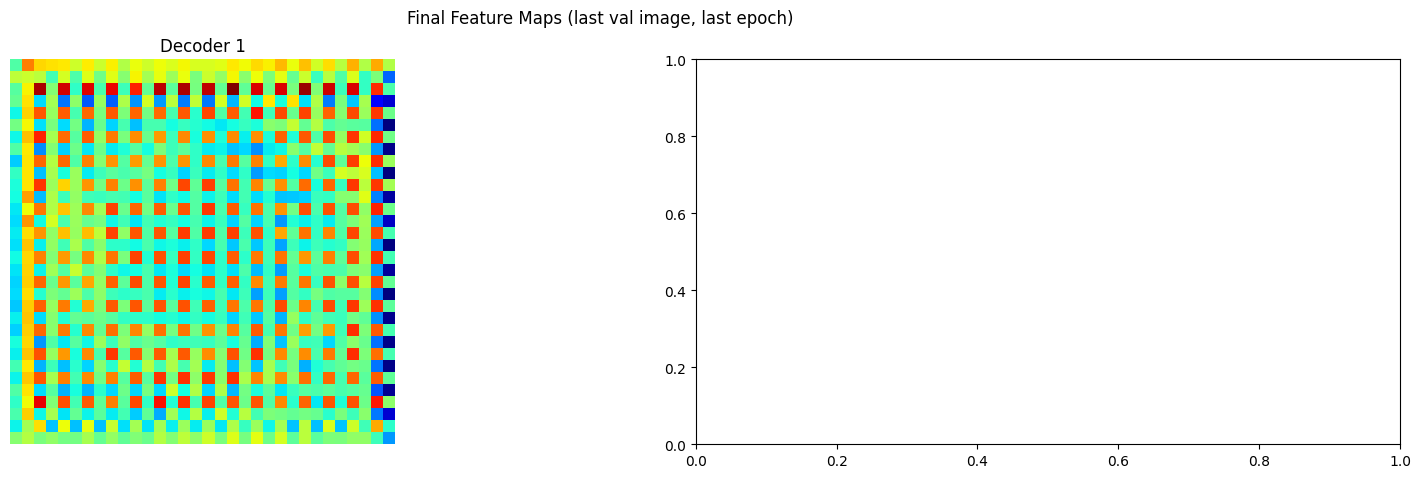

In [ ]:


# Train with dataset
modelzp_nlb.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=2,
    callbacks=[callbacks, feature_map_callback],
)

In [ ]:
modelzp_nlb.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8323 - dice_coef: 0.2119 - iou: 0.0906 - loss: 0.7877 - precision: 0.4623 - recall: 0.1000


[0.7882606387138367,
 0.2110947072505951,
 0.09314391016960144,
 0.8330132961273193,
 0.10367245972156525,
 0.42614784836769104]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


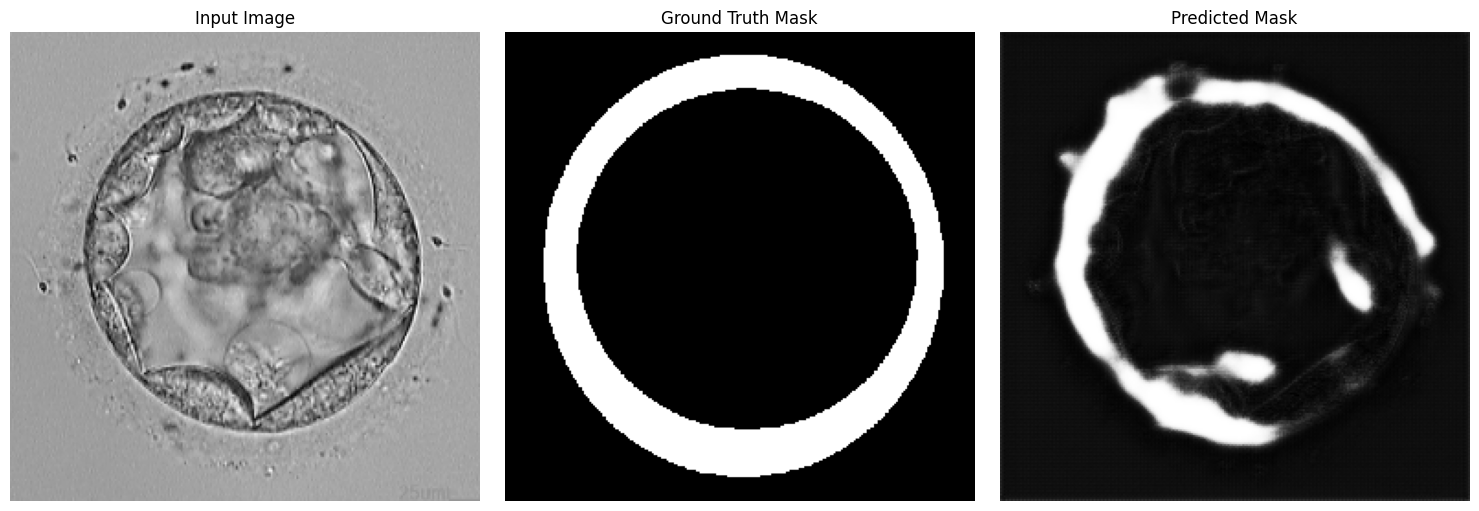

In [ ]:

pred_dict = modelzp_nlb.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def build_unetspt(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    b1 = conv_block(p4, 1024, dropout=True)

    d1,SA1 = decoder_blocknlb(b1, s4, 512, name_prefix="decoder1")
    d2,SA2= decoder_blocksp(d1, s3, 256,name_prefix="decoder2")
    d3,SA3 = decoder_blocksp(d2, s2, 128,name_prefix="decoder3")
    d4,SA4 = decoder_blocksp(d3, s1, 64,name_prefix="decoder4")
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid", name="segmentation_output")(d4)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelzp_spt = build_unetspt(input_shape)
modelzp_spt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
for layer in modelzp_spt.layers:
    print(layer.name)


input_layer
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_2
activation_2
conv2d_3
batch_normalization_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_4
activation_4
conv2d_5
batch_normalization_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_6
activation_6
conv2d_7
batch_normalization_7
activation_7
dropout
max_pooling2d_3
conv2d_8
batch_normalization_8
activation_8
conv2d_9
batch_normalization_9
activation_9
dropout_1
conv2d_transpose
concatenate
conv2d_10
conv2d_11
lambda
lambda_1
lambda_3
conv2d_12
activation_10
lambda_2
lambda_4
lambda_5
conv2d_13
batch_normalization_10
decoder1_nlbattention_final_add
conv2d_14
batch_normalization_11
activation_11
conv2d_15
batch_normalization_12
activation_12
conv2d_16
batch_normalization_13
activation_13
conv2d_17
batch_normalization_14
activation_14
conv2d_transpose_1
conv2d_18
conv2d_19
conv2d_21
conv2d_22
add
add_1
activation_15
activation_16

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",
    "decoder2_dualattention_outskip",
    "decoder3_dualattention_outskip",
    "decoder4_dualattention_outskip",
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_spt.input,
                                   outputs=[modelzp_spt.get_layer(name).output for name in layer_names])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 714s 10s/step - accuracy: 0.5510 - dice_coef: 0.3698 - iou: 0.2750 - loss: 0.6303 - precision: 0.2566 - recall: 0.8807 - val_accuracy: 0.8275 - val_dice_coef: 0.2143 - val_iou: 0.0388 - val_loss: 0.7802 - val_precision: 0.3399 - val_recall: 0.0524 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9156 - dice_coef: 0.6490 - iou: 0.6310 - loss: 0.3510 - precision: 0.6681 - recall: 0.9189 - val_accuracy: 0.8259 - val_dice_coef: 0.2130 - val_iou: 0.0825 - val_loss: 0.7764 - val_precision: 0.3979 - val_recall: 0.1149 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9369 - dice_coef: 0.7086 - iou: 0.6993 - loss: 0.2914 - precision: 0.7503 - recall: 0.9123 - val_accuracy: 0.8306 - val_dice_coef: 0.1665 - val_iou: 0.0431 - val_loss: 0.8236 - val_precision: 0.3989 - val_recall: 0.0599 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accur

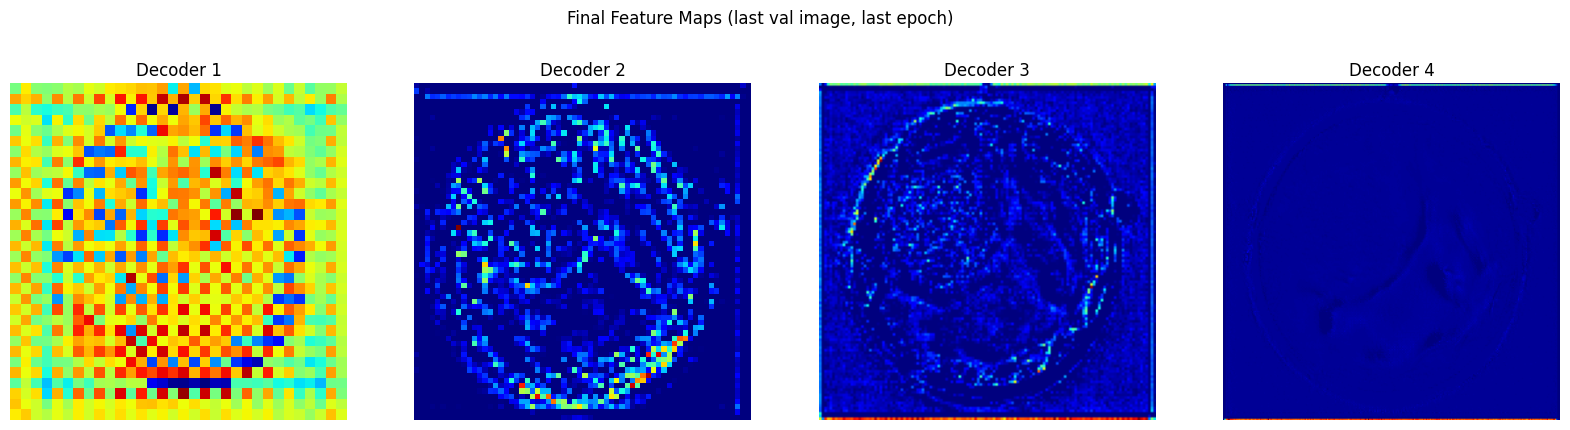

In [ ]:


# Train with dataset
modelzp_spt.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[callbacks,feature_map_callback]
)

In [ ]:
modelzp_spt.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9594 - dice_coef: 0.8689 - iou: 0.7760 - loss: 0.1329 - precision: 0.9120 - recall: 0.8341


[0.1306125521659851,
 0.8720978498458862,
 0.7815038561820984,
 0.9609808325767517,
 0.8359680771827698,
 0.9146270751953125]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


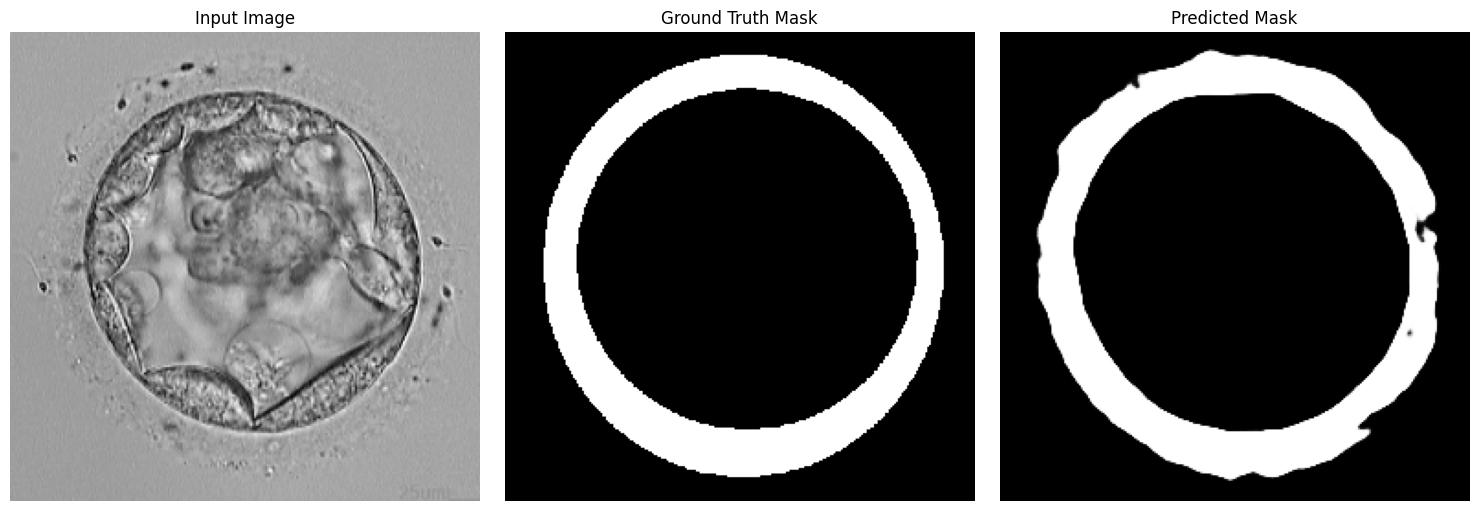

In [ ]:

pred_dict = modelzp_spt.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def decoder_blockspc(x,skip, filters,name_prefix="decoder"):
    x = conv_block(x, filters*2)
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    skipatt=dual_pathway_spatial_attention(skip,x,filters,name_prefix=f"{name_prefix}_dualattention")
    x = layers.Concatenate(axis=-1)([x, skipatt])
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,skipatt


In [ ]:
def decoder_blocknlbc(x, skip, filters,name_prefix="decoder"):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x,f = SA1_non_local_attention(x,name_prefix=f"{name_prefix}_nlbattention")
    x = conv_block(x, filters)
    x,vec,ch=channel_attention(x,name_prefix=f"{name_prefix}_channelattention")
    return x,vec,ch,f


In [ ]:
def build_unetsptc(input_shape):
    inputs = tf.keras.Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    d1,vec,ch1,SA1 = decoder_blocknlbc(b1, s4, 512,name_prefix="decoder1")
    d2,vec,ch2,SA2 = decoder_blockspc(d1, s3, 256,name_prefix="decoder2")
    d3,vec,ch3,SA3 = decoder_blockspc(d2, s2, 128,name_prefix="decoder3")
    d4,vec,ch4,SA4 = decoder_blockspc(d3, s1, 64,name_prefix="decoder4")

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    return Model(inputs, outputs)

In [ ]:
input_shape = ((SIZE, SIZE, 3))
modelzp_sptc = build_unetsptc(input_shape)
modelzp_sptc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [ ]:
layer_names = [
    "decoder1_nlbattention_final_add",
    "decoder1_channelattention_final_add",
    "decoder2_dualattention_outskip",
    "decoder2_channelattention_final_add",
    "decoder3_dualattention_outskip",
    "decoder3_channelattention_final_add",
    "decoder4_dualattention_outskip",
    "decoder4_channelattention_final_add"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_sptc.input,
                                   outputs=[modelzp_sptc.get_layer(name).output for name in layer_names])



In [ ]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5447 - dice_coef: 0.3772 - iou: 0.2680 - loss: 0.6229 - precision: 0.2680 - recall: 0.8620 - val_accuracy: 0.8176 - val_dice_coef: 0.2223 - val_iou: 0.0244 - val_loss: 0.7736 - val_precision: 0.2010 - val_recall: 0.0368 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9251 - dice_coef: 0.7354 - iou: 0.6523 - loss: 0.2645 - precision: 0.7145 - recall: 0.8824 - val_accuracy: 0.8355 - val_dice_coef: 0.1444 - val_iou: 8.4262e-21 - val_loss: 0.8527 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9444 - dice_coef: 0.7963 - iou: 0.7162 - loss: 0.2038 - precision: 0.8003 - recall: 0.8734 - val_accuracy: 0.8470 - val_dice_coef: 0.2654 - val_iou: 0.1515 - val_loss: 0.7304 - val_precision: 0.6284 - val_recall: 0.1697 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/st

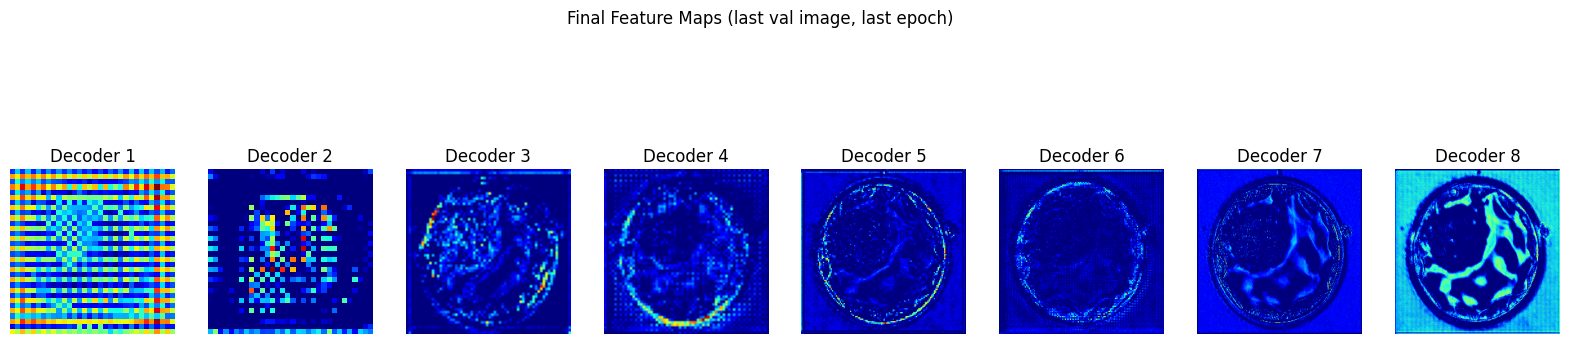

In [ ]:


# Train with dataset
modelzp_sptc.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[callbacks,feature_map_callback]
)

In [ ]:
modelzp_sptc.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.9500 - dice_coef: 0.8418 - iou: 0.7285 - loss: 0.1590 - precision: 0.8780 - recall: 0.8085


In [22]:
def scale_attention_module(features,name_prefix="attention"):
    """
    Paper-faithful Scale Attention Module (CA-Net) with symbolic shape fix.
    Args:
        features: list of decoder feature maps from 4 different scales (d1 to d4)
    Returns:
        Final enhanced feature map (B, H, W, 4)
    """
    H, W = features[3].shape[1], features[3].shape[2]  # symbolic-safe shape

    # 1. Resize all feature maps to same shape
    resized = [layers.Resizing(H, W, interpolation='bilinear')(f) for f in features]

    # 2. Compress to 1 channel per scale
    compressed = [layers.Conv2D(1, (1, 1), padding='same')(f) for f in resized]

    # 3. Concatenate → F̂ (B, H, W, 4)
    F_hat = layers.Concatenate(axis=-1)(compressed)
    shared_dense_one = layers.Dense(4//2 , activation='relu', kernel_initializer='he_normal')
    shared_dense_two = layers.Dense(4, kernel_initializer='he_normal')
    # 4. Scale-wise attention γ
    gap = layers.GlobalAveragePooling2D()(F_hat)
    gmp = layers.GlobalMaxPooling2D()(F_hat)
    gap = layers.Reshape((1, 1, 4))(gap)
    gmp = layers.Reshape((1, 1, 4))(gmp)
    gap = shared_dense_two(shared_dense_one(gap))
    gmp = shared_dense_two(shared_dense_one(gmp))
    gamma = layers.Add()([gap, gmp])
    gamma = layers.Activation('sigmoid')(gamma)  # (B, 1, 1, 4)

    F_gamma = layers.Multiply()([F_hat, gamma])  # (B, H, W, 4)

    # 5. Pixel-wise scale attention γ*
    x = layers.Conv2D(4, (3, 3), padding='same', activation='relu')(F_gamma)
    gamma_star = layers.Conv2D(4, (1, 1), padding='same', activation='sigmoid')(x)


    # 6. Final residual + fused output
    out = layers.Add(name=f"{name_prefix}_final")([
        layers.Multiply()([F_gamma, gamma_star]),
        layers.Multiply()([F_hat, gamma]),
        F_hat
    ])
    """
    x = layers.Activation("relu")(out)
    x = layers.Conv2D(4, (3, 3), padding="same", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu",name=f"{name_prefix}_final")(x)
    """
    return out


In [23]:
def build_unetsc(input_shape):
    inputs = tf.keras.Input(input_shape)

    # ---- Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4 = conv_block(p3, 512, dropout=True)
    p4 = layers.MaxPooling2D((2, 2))(s4)

    # Apply dropout in bottleneck
    b1 = conv_block(p4, 1024, dropout=True)

    # ---- Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # ---- Scale Attention Module
    la_output = scale_attention_module([d1, d2, d3, d4],name_prefix="scaler")  # returns enhanced feature map

    # ---- Final Output
    output = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid',name="segmentation_output")(la_output)

    return Model(inputs=inputs, outputs=output)


In [24]:
# Now build and compile model like you did
input_shape = ((SIZE, SIZE, 3))
modelzp_sc = build_unetsc(input_shape)
modelzp_sc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, weight_decay=1e-8),
    loss=dice_loss,
    metrics=metrics
)

In [25]:
layer_names = [
"scaler_final"
]
# Create a new model that outputs the attention layers
feature_extractor = tf.keras.Model(inputs=modelzp_sc.input,
                                   outputs=[modelzp_sc.get_layer(name).output for name in layer_names])



In [26]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

class FinalFeatureMapCallback(tf.keras.callbacks.Callback):
    def __init__(self, feature_extractor, val_data):
        super(FinalFeatureMapCallback, self).__init__()
        self.feature_extractor = feature_extractor
        self.val_data = val_data

    def on_train_end(self, logs=None):
        # Get the last image from the last batch of val_data
        last_image = None
        for batch in self.val_data:
            last_image = batch[0]  # (inputs, labels)

        if last_image is None:
            print("Validation data is empty.")
            return

        image = last_image[-1:]  # shape (1, H, W, C)

        # Get feature maps
        feature_maps = self.feature_extractor.predict(image)

        # Plot the first channel of each decoder output
        fig, axes = plt.subplots(1, 2, figsize=(20, 5))
        for i, fmap in enumerate(feature_maps):
            fmap = np.squeeze(fmap)  # (H, W, C)
            axes[i].imshow(fmap[:, :, 0], cmap='jet')  # first channel
            axes[i].set_title(f'Decoder {i + 1}')
            axes[i].axis('off')

        plt.suptitle('Final Feature Maps (last val image, last epoch)')
        plt.show()


In [27]:
feature_map_callback = FinalFeatureMapCallback(feature_extractor, val_data=valid_dataset)


In [ ]:


# Train with dataset
modelzp_sc.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    callbacks=[callbacks,feature_map_callback]
)

Epoch 1/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 551s 8s/step - accuracy: 0.8131 - dice_coef: 0.5471 - iou: 0.4024 - loss: 0.4529 - precision: 0.3251 - recall: 0.8217 - val_accuracy: 0.8151 - val_dice_coef: 0.0994 - val_iou: 0.0226 - val_loss: 0.8966 - val_precision: 0.1629 - val_recall: 0.0301 - learning_rate: 1.0000e-04
Epoch 2/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9375 - dice_coef: 0.8086 - iou: 0.6846 - loss: 0.1914 - precision: 0.7856 - recall: 0.8424 - val_accuracy: 0.7873 - val_dice_coef: 0.2854 - val_iou: 0.1645 - val_loss: 0.7135 - val_precision: 0.3168 - val_recall: 0.2539 - learning_rate: 1.0000e-04
Epoch 3/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9486 - dice_coef: 0.8399 - iou: 0.7283 - loss: 0.1601 - precision: 0.8189 - recall: 0.8684 - val_accuracy: 0.8427 - val_dice_coef: 0.2658 - val_iou: 0.1483 - val_loss: 0.7294 - val_precision: 0.5721 - val_recall: 0.1716 - learning_rate: 1.0000e-04
Epoch 4/200
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accu

In [ ]:
modelzp_sc.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.7916 - dice_coef: 0.2505 - iou: 0.1087 - loss: 0.7471 - precision: 0.2630 - recall: 0.1486


[0.7501688599586487,
 0.24620524048805237,
 0.11598773300647736,
 0.7926867604255676,
 0.15884831547737122,
 0.2630796730518341]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


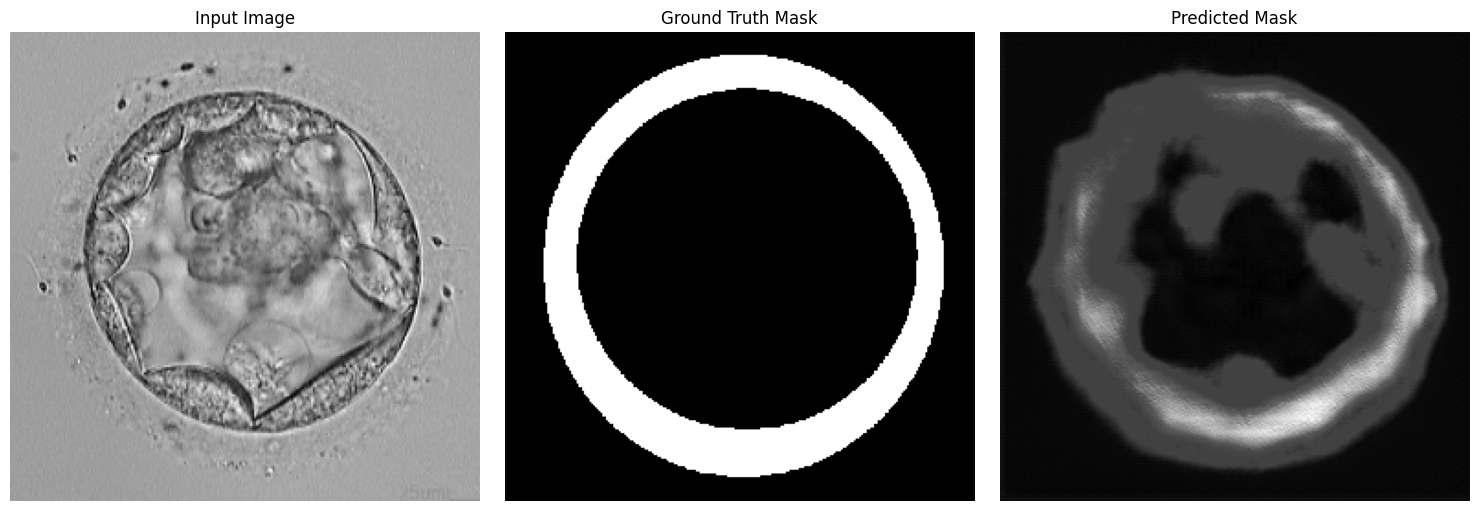

In [ ]:

pred_dict = modelzp_sc.predict(sample_img_exp)
output = pred_dict[0]  # (H, W, 1)

# Plotting
plt.figure(figsize=(15, 5))

# Input image
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Input Image")
plt.axis('off')

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(sample_mask[..., 0] if sample_mask.ndim == 3 else sample_mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(output[..., 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
